## Classification
1. Feature processing: scaling, selection
2. Classify

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# !cp drive/MyDrive/UNI/IPOTERI/data . -r

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import sample

plt.style.use('ggplot')
%matplotlib inline

In [3]:
# utility function to report the best models during model selection
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates[:1]:
            print("Model rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


3934
984
1230
6148


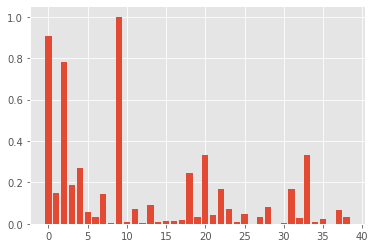

In [6]:
# 2. feature processing
import scipy.stats as stats
from joblib import dump, load
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score, fbeta_score, make_scorer, accuracy_score, plot_confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, learning_curve, validation_curve
from sklearn.utils.class_weight import compute_class_weight

years = 7
df_train = pd.read_csv(f"data/{years}y/train.csv", index_col=0).to_numpy()
df_valid = pd.read_csv(f"data/{years}y/valid.csv", index_col=0).to_numpy()
df_test = pd.read_csv(f"data/{years}y/test.csv", index_col=0).to_numpy()
X_train, y_train = df_train[:, :-1], df_train[:, -1]
X_valid, y_valid = df_valid[:, :-1], df_valid[:, -1]

numerical_features = list(range(8))+list(range(20, 24))
preprocess_minmax = ColumnTransformer(
                            transformers = [('minmax', MinMaxScaler(), numerical_features)], 
                            remainder="passthrough"
                            )
preprocess_std = ColumnTransformer(
                            transformers = [('stand', StandardScaler(), numerical_features)], 
                            remainder="passthrough"
                            )
preprocess_std_all = StandardScaler()


# feature selection
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif, chi2
selector = SelectKBest(chi2, k=15)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(range(df_train.shape[-1]-1), scores)

# print(len(df_train))
# print(len(df_valid))
# print(len(df_test))
# print(len(df_train)+len(df_valid)+len(df_test))

In [ ]:
# # custom metrics
# def custom(y_true, y_pred):
#     tp = ((y_true==1) & (y_pred==1)).sum()
#     tn = ((y_true==0) & (y_pred==0)).sum()
#     fp = ((y_true==0) & (y_pred==1)).sum()
#     fn = ((y_true==1) & (y_pred==0)).sum()
#     if tp <= 100:
#         return 100
#     else: 
#         return fp / (fp + tn)

# score = make_scorer(custom, greater_is_better=False)

# # f2 if FN are more costly, f05 if FP are more costly
# f1_negative = make_scorer(f1_score, pos_label=0)
# f2_negative = make_scorer(fbeta_score, beta=2, pos_label=0)
# f05_negative = make_scorer(fbeta_score, beta=0.5, pos_label=0)

In [ ]:
# 3. classify
# FP = network says survive=T but data says survive=F
# FN = network says survive=F but data says survive=T
# the goal is to minimize the FP, we don't want the model to "hide the sick patients"
from sklearn.linear_model import LogisticRegression

pipe = Pipeline(steps=[
                    # ('selection', selector), 
                    ('preprocess', preprocess_std_all), 
                    # ('preprocess', preprocess_std), 
                    ('model', LogisticRegression(solver="lbfgs", class_weight="balanced"))
                ])

pipe.fit(X_train, y_train)
y = pipe.predict(X_valid)
print(classification_report(y_valid, y, digits=3))
print(f"auc macro {roc_auc_score(y_valid, pipe.predict_proba(X_valid)[:, 1]):.3f}")
plot_confusion_matrix(pipe, X_valid, y_valid, normalize=None)
plt.grid(False)
print(f1_score(y_valid, y, average="micro"))

metrics.plot_roc_curve(pipe, X_valid, y_valid)

# import math
# w = logreg.coef_[0]
# feature_importance = pd.DataFrame(df_feat.columns[:-1], columns=["features"])
# feature_importance["importance"] = pow(math.e, w)
# feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
# feature_importance

# save and load
# dump(pipe["model"], path+"logreg.joblib")
# test = load(path+"logreg.joblib")

In [ ]:
from sklearn.svm import SVC

hyperparams = {
    'model__C': stats.randint(1, 30),
    'model__kernel': ['rbf'],
    'model__degree': stats.randint(20, 80),
    'model__max_iter': stats.randint(500, 1500)
}

pipe = Pipeline(steps=[
                    # ('selection', selector), 
                    # ('preprocess', preprocess_std), 
                    ('preprocess', preprocess_std_all), 
                    ('model', SVC(class_weight="balanced", probability=True))
                ])

svc_rand = RandomizedSearchCV(pipe,
                            param_distributions=hyperparams,
                            # scoring='f1_macro',
                            # scoring=f1_negative,
                            # scoring=score,
                            # scoring=f05_negative,
                            scoring="accuracy",
                            n_iter=5000,
                            cv=2,
                            n_jobs=-1,  # use all processors
                            refit=True,  # refit the best model at the end
                            return_train_score=True,
                            verbose=True).fit(X_train, y_train)

y = svc_rand.best_estimator_.predict(X_valid)
print(classification_report(y_valid, y, digits=3))
print(f"auc macro {roc_auc_score(y_valid, svc_rand.predict_proba(X_valid)[:, 1]):.3f}")
plot_confusion_matrix(svc_rand.best_estimator_, X_valid, y_valid, normalize=None)
plt.grid(False)
report(svc_rand.cv_results_, n_top=3)

# save and load
# dump(svc_rand.best_estimator_["model"], path+"svc.joblib")
# test = load(path+"svc.joblib")

In [ ]:
from sklearn.ensemble import RandomForestClassifier

hyperparams = {
    'model__n_estimators': stats.randint(30, 60),
    'model__criterion': ('gini', 'entropy'),
    'model__max_depth': stats.randint(1, 20),
    'model__min_samples_split': stats.randint(2, 10),
    'model__min_samples_leaf': stats.randint(1, 5),
    'model__max_features': ('sqrt', 'log2'),
}

pipe = Pipeline(steps=[
                    # ('selection', selector), 
                    ('preprocess', preprocess_std_all), 
                    ('model', RandomForestClassifier(class_weight="balanced"))
                ])

rf_rand = RandomizedSearchCV(pipe,
                            param_distributions=hyperparams,
                            scoring="accuracy",
                            # scoring='precision',
                            # scoring=f1_macro_negative,
                            # scoring="f1_macro",
                            # scoring=score,
                            n_iter=5000,
                            cv=2,
                            n_jobs=-1,  # use all processors
                            refit=True,  # refit the best model at the end
                            return_train_score=True,
                            verbose=True).fit(X_train, y_train)

y = rf_rand.best_estimator_.predict(X_valid)
print(classification_report(y_valid, y, digits=3))
print(f"auc macro {roc_auc_score(y_valid, rf_rand.predict_proba(X_valid)[:, 1]):.3f}")
plot_confusion_matrix(rf_rand.best_estimator_, X_valid, y_valid, normalize=None)
plt.grid(False)
report(rf_rand.cv_results_, n_top=3)

# feature importance use permutation importance
# importance = rf_rand.best_estimator_["model"].feature_importances_
# plt.bar(list(range(len(importance))), importance)

# save and load
# dump(rf_rand.best_estimator_["model"], path+"rf.joblib")
# test = load(path+"rf.joblib")

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

hyperparams = {
    'model__n_neighbors': stats.randint(2, 20),
    'model__weights': ('uniform', 'distance'),
    'model__algorithm': ('ball_tree', 'kd_tree', 'brute')
}

pipe = Pipeline(steps=[
                    # ('selection', selector), 
                    ('preprocess', preprocess_std_all), 
                    ('model', KNeighborsClassifier())
                ])

knn_rand = RandomizedSearchCV(pipe,
                            param_distributions=hyperparams,
                            # scoring="f1_macro",
                            # scoring=f1_macro_negative,
                            scoring="accuracy",
                            # scoring=score,
                            n_iter=5000,
                            cv=2,
                            n_jobs=-1,  # use all processors
                            refit=True,  # refit the best model at the end
                            return_train_score=True,
                            verbose=True).fit(X_train, y_train)

y = knn_rand.best_estimator_.predict(X_valid)
print(classification_report(y_valid, y, digits=3))
print(f"auc macro {roc_auc_score(y_valid, pipe.predict_proba(X_valid)[:, 1]):.3f}")
plot_confusion_matrix(knn_rand.best_estimator_, X_valid, y_valid, normalize=None)
plt.grid(False)
report(knn_rand.cv_results_, n_top=3)

# save and load
# dump(knn_rand.best_estimator_["model"], path+"knn.joblib")
# test = load(path+"knn.joblib")

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

hyperparams = {
    'model__loss': ('deviance', 'exponential'),
    'model__learning_rate': stats.uniform(0.05, 0.2),
    'model__n_estimators': stats.randint(50, 150),
    'model__criterion': ('friedman_mse', 'mse', 'mae'),
    'model__min_samples_split': stats.randint(2, 4),
    'model__min_samples_leaf': stats.randint(1, 2),
    'model__max_depth': stats.randint(3, 6),
}

pipe = Pipeline(steps=[
                    # ('selection', selector), 
                    ('preprocess', preprocess_std_all), 
                    ('model', GradientBoostingClassifier())
                ])

gb_rand = RandomizedSearchCV(pipe,
                            param_distributions=hyperparams,
                            # scoring="f1_macro",
                            # scoring=f1_macro_negative,
                            scoring="accuracy",
                            # scoring=score,
                            n_iter=1000,
                            cv=2,
                            n_jobs=-1,  # use all processors
                            refit=True,  # refit the best model at the end
                            return_train_score=True,
                            verbose=True).fit(X_train, y_train)

y = gb_rand.best_estimator_.predict(X_valid)
print(classification_report(y_valid, y, digits=3))
print(f"auc macro {roc_auc_score(y_valid, pipe.predict_proba(X_valid)[:, 1]):.3f}")
plot_confusion_matrix(gb_rand.best_estimator_, X_valid, y_valid, normalize=None)
plt.grid(False)
report(gb_rand.cv_results_)

# save and load
# dump(gb_rand.best_estimator_["model"], path+"gb.joblib")
# test = load(path+"gb.joblib")

In [ ]:
from sklearn.neural_network import MLPClassifier
from random import random

hyperparams = {
    'model__hidden_layer_sizes': stats.randint.rvs(10, 100, size=round(random()*2)+1),
    'model__activation': ('logistic', 'tanh', 'relu'),
    'model__solver': ('lbfgs', 'sgd', 'adam'),
    'model__learning_rate_init': stats.uniform(0.001, 0.01),
    'model__alpha': stats.uniform(),
    'model__max_iter': stats.randint(25, 300),
}

pipe = Pipeline(steps=[
                    # ('selection', selector), 
                    ('preprocess', preprocess_std_all), 
                    ('model', MLPClassifier())
                ])

nn_rand = RandomizedSearchCV(pipe,
                            param_distributions=hyperparams,
                            # scoring='f1_macro',
                            scoring='accuracy',
                            n_iter=500,
                            cv=2,
                            n_jobs=-1,  # use all processors
                            refit=True,  # refit the best model at the end
                            return_train_score=True,
                            verbose=True).fit(X_train, y_train)

y = nn_rand.best_estimator_.predict(X_valid)
print(classification_report(y_valid, y, digits=3))
print(f"auc macro {roc_auc_score(y_valid, nn_rand.predict_proba(X_valid)[:, 1]):.3f}")
plot_confusion_matrix(nn_rand.best_estimator_, X_valid, y_valid, normalize=None)
plt.grid(False)
report(nn_rand.cv_results_)

# save and load
# dump(nn_rand.best_estimator_["model"], path+"nn.joblib")
# test = load(path+"nn.joblib")

## Feature Selection
Testing with Feature Selection algorithms, RFECV and SFS

In [ ]:
# !pip uninstall scikit-learn -y
# !pip install -U scikit-learn
# !pip install imblearn

In [ ]:
from sklearn.feature_selection import RFECV

pipe = load(path+"logreg.joblib")
preprocess_std_all = preprocess_std_all.fit(X_train)
X_train_std = preprocess_std_all.transform(X_train)
X_valid_std = preprocess_std_all.transform(X_valid)

selector = RFECV(pipe, min_features_to_select=10, cv=5, scoring="accuracy")
selector = selector.fit(X_train_std, y_train)

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

mlp = load(path+"nn.joblib")
pipe = Pipeline(steps=[
                    # ('selection', selector),
                    ('preprocess', preprocess_std_all), 
                    ('model', mlp)
                ])

selector = SequentialFeatureSelector(pipe, n_features_to_select=25, direction="backward", cv=5, scoring="accuracy")
selector = selector.fit(X_train, y_train)

In [ ]:
print(len(feature_names[selector.get_support()]))
print(feature_names[selector.get_support()])

X_train_select = selector.transform(X_train)
X_valid_select = selector.transform(X_valid)

pipe.fit(X_train_select, y_train)
y = pipe.predict(X_valid_select)

print(classification_report(y_valid, y, digits=3))
print(f"auc macro {roc_auc_score(y_valid, pipe.predict_proba(X_valid_select)[:, 1]):.3f}")
plot_confusion_matrix(pipe, X_valid_select, y_valid, normalize=None)
plt.grid(False)